# Importera nödvändiga paket

In [2]:
from __future__ import print_function
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

Using TensorFlow backend.


# Läs in terminsdata från csv-fil

In [3]:
#tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('precision', 7)
semesters = pd.read_csv('terminsstatus_17.txt', sep = '\t')
semesters.head()

,program,lopnr,female,kull,termin,tnr,status,poang_p,kullnr,ptnr
0,E,1,0,20002,20002,15,-7,6.0,15,1
1,W,2,1,20112,20112,37,-7,15.0,37,1
2,D,3,1,20032,20032,21,-7,16.5,21,1
3,N,4,1,20112,20112,37,-7,30.0,37,1
4,W,5,1,20112,20112,37,-7,0.0,37,1


# Lägg till kolumn för poäng tagna föregående termin. Om föregående termin ej finns, gissa på medelvärdet av alla terminer 

In [4]:
delay_one_term = lambda x: x.shift(+1)
prev_semesters = semesters.apply(delay_one_term)
mean_points = semesters.poang_p.mean()

prev = []
for i,s in enumerate(semesters.lopnr):
    if s == prev_semesters.at[i,'lopnr']:
        prev.append(prev_semesters.at[i, 'poang_p'])
    else:
        prev.append(mean_points)
prev_points_pd = pd.DataFrame(prev)
semesters['prev_points'] = prev_points_pd

# Lägg till kolumn för poäng tagna första termin

In [5]:
lopnr_prev = 0
points_first_semester = []
for i, s in enumerate(semesters.lopnr):
    if s != lopnr_prev:
        p = semesters.at[i, 'poang_p']
        points_first_semester.append(p)
    else:
        points_first_semester.append(p)
    lopnr_prev = s
pfs_pd = pd.DataFrame(points_first_semester)
semesters['points_first_semester'] = pfs_pd

# Lägg till kolumn för ackumulerade poäng

In [6]:
lopnr_prev = 0
acc_points = []
for i, p in enumerate(semesters.lopnr):
    if p != lopnr_prev:
        acc_points.append(semesters.at[i,'poang_p'])
    else:
        acc_points.append(acc_points[i-1] + semesters.at[i,'poang_p'])
    lopnr_prev = p
acc_points_pd = pd.DataFrame(acc_points)
#acc_points_pd.head(20)
semesters['accumulated_points'] = acc_points_pd

# Kolumn för terminstyp (vår/Höst)

In [34]:
semester_type = lambda x: "spring" if int(str(x)[-1]) == 1 else "fall" #funktion som tar fram sista siffran ur en integer
semesters['semester_type'] = semesters.termin.apply(semester_type) # lägg till ny kolumn i datamängden (vår/höst)

semester_types = pd.get_dummies(semesters['semester_type'])
semesters2 = pd.concat([semesters, semester_types], axis=1)
semesters2.head()

,program,lopnr,female,kull,termin,tnr,status,poang_p,kullnr,ptnr,prev_points,points_first_semester,accumulated_points,semester_type,zero_semesters,one_hot,fall,spring
0,E,1,0,20002,20002,15,-7,6.0,15,1,16.1,6.0,6.0,fall,0,E,1,0
1,W,2,1,20112,20112,37,-7,15.0,37,1,16.1,15.0,15.0,fall,0,W,1,0
2,D,3,1,20032,20032,21,-7,16.5,21,1,16.1,16.5,16.5,fall,0,D,1,0
3,N,4,1,20112,20112,37,-7,30.0,37,1,16.1,30.0,30.0,fall,0,N,1,0
4,W,5,1,20112,20112,37,-7,0.0,37,1,16.1,0.0,0.0,fall,1,W,1,0


# Lägg till kolumn för antalet 0-terminer

In [70]:
pd.options.display.max_rows = 40
lopnr_prev = 0
zero_semesters = [0]*semesters.shape[0]
for i, s in enumerate(semesters.lopnr):
    if semesters.at[i,'poang_p'] == 0:
        if s != lopnr_prev:
            zero_semesters[i] += 1
        else:
            zero_semesters[i] = zero_semesters[i-1]+1
        lopnr_prev = s
    else:
        zero_semesters[i] = 0
zs_pd = pd.DataFrame(zero_semesters)
semesters2['zero_semesters'] = zs_pd
semesters2.head()

,program,lopnr,female,kull,termin,tnr,status,poang_p,kullnr,ptnr,...,2,3,4,5,6,7,8,9,10,lopnr_scaled
0,E,1,0,20002,20002,15,-7,6.0,15,1,...,0,0,0,0,0,0,0,0,0,-2.0
1,W,2,1,20112,20112,37,-7,15.0,37,1,...,0,0,0,0,0,0,0,0,0,-2.0
2,D,3,1,20032,20032,21,-7,16.5,21,1,...,0,0,0,0,0,0,0,0,0,-2.0
3,N,4,1,20112,20112,37,-7,30.0,37,1,...,0,0,0,0,0,0,0,0,0,-2.0
4,W,5,1,20112,20112,37,-7,0.0,37,1,...,0,0,0,0,0,0,0,0,0,-2.0


# Se korrelation mellan features och target

In [71]:
pd.set_option("display.precision", 5)
correlation_dataframe = semesters2[['prev_points', 'points_first_semester', 'accumulated_points', 'zero_semesters']]
correlation_dataframe["target"] = semesters2["poang_p"]
#with pd.option_context('display.float_format', '{:0.20f}'.format):
print((correlation_dataframe.corr(method ='pearson')).values)
(correlation_dataframe.corr(method ='pearson'))


[[ 1.          0.40068405  0.24993911 -0.51408437  0.54570624]
 [ 0.40068405  1.          0.3357679  -0.349628    0.40950925]
 [ 0.24993911  0.3357679   1.         -0.20547186  0.1748101 ]
 [-0.51408437 -0.349628   -0.20547186  1.         -0.50278541]
 [ 0.54570624  0.40950925  0.1748101  -0.50278541  1.        ]]


/Users/filipvitez/anaconda3/envs/matmod_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,prev_points,points_first_semester,accumulated_points,zero_semesters,target
prev_points,1.0,0.4,0.2,-0.5,0.5
points_first_semester,0.4,1.0,0.3,-0.3,0.4
accumulated_points,0.2,0.3,1.0,-0.2,0.2
zero_semesters,-0.5,-0.3,-0.2,1.0,-0.5
target,0.5,0.4,0.2,-0.5,1.0


# One hot-encoda program, kull och status (lopnr hade också behövts men blir för lång vektor)

In [72]:
semesters['one_hot'] = pd.Categorical(semesters['program'])

dfDummies = pd.get_dummies(semesters['one_hot'])
semesters2 = pd.concat([semesters2, dfDummies],axis=1)

semesters2['one_hot2'] = pd.Categorical(semesters2['kull'])
one_hot_kull = pd.get_dummies(semesters2['one_hot2'])


one_hot_termstatus = pd.get_dummies(semesters2['status'])

semesters2 = pd.concat([semesters2, one_hot_kull], axis=1)
semesters2 = pd.concat([semesters2, one_hot_termstatus], axis=1)
semesters2.columns

Index(['program',   'lopnr',  'female',    'kull',  'termin',     'tnr',
        'status', 'poang_p',  'kullnr',    'ptnr',
       ...
               1,         2,         3,         4,         5,         6,
               7,         8,         9,        10],
      dtype='object', length=126)

# Välj vilka features vi vill ha till det neurala nätverket

In [73]:
mean = semesters.lopnr.describe()['mean']
std = semesters.lopnr.describe()['std']
print(mean)
print(std)

lopnr_list = [0]*len(semesters.lopnr)
lopnummer = semesters2.lopnr
for i, l in enumerate(lopnummer):
    ll = float((float(l) - mean)/std)
    lopnr_list[i] = ll

print(lopnr_list[0])
npa = np.asarray(lopnr_list, dtype=np.float32)
npa
pd.options.display.precision = 5
lopnr_scaled = pd.DataFrame(npa, dtype=np.float32)
lopnr_scaled.values
semesters2['lopnr_scaled'] = lopnr_scaled.values
semesters2.lopnr_scaled.values

11260.378214065691
5693.381743515426
-1.9776257277829212


array([-1.9776257, -1.9774501, -1.9772744, ...,  1.9827621,  1.9829378,
        1.9831134], dtype=float32)

In [74]:
#x = (semesters2[['status', 'prev_points', 'points_first_semester', 'accumulated_points', 'zero_semesters', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'P', 'T', 'V', 'W', 19932, 19942,19952,19962, 19972, 19982, 19992, 20002,20012,20022, 20032, 20042, 20052, 20062, 20072, 20082, 20092, 20102, 20112,20132, 20142, 20152]]).values
#x = (semesters2[['lopnr','female','status', 'prev_points', 'points_first_semester', 'accumulated_points', 'zero_semesters', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'P', 'T', 'V', 'W']]).values
#x = (semesters2[['lopnr_scaled', 'female', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'P', 'T', 'V', 'W', -7, -5, -4, -3, -2, 1,2,3,4,5,6,7,8,9,10]]).values
#x = (semesters2[['female', 'prev_points', 'points_first_semester', 'accumulated_points', 'zero_semesters', -7, -5, -4, -3, -2, 1,2,3,4,5,6,7,8,9,10]]).values
#x = (semesters2[['prev_points', 'points_first_semester', 'accumulated_points',1,2, 'zero_semesters', -7, -5, -4, -3, -2, 1,2,3,4,5,6,7,8,9,10]]).values

x = (semesters2[['lopnr_scaled', 'female', 'prev_points', 'points_first_semester', 'fall', 'spring', 'accumulated_points', 'zero_semesters', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'P', 'T', 'V', 'W', -7, -5, -4, -3, -2, 1,2,3,4,5,6,7,8,9,10]]).values
y = semesters2.iloc[:, 8].values


print(x)
x.shape


[[-1.97762573  0.         16.11571366 ...  0.          0.
   0.        ]
 [-1.97745013  1.         16.11571366 ...  0.          0.
   0.        ]
 [-1.97727442  1.         16.11571366 ...  0.          0.
   0.        ]
 ...
 [ 1.9827621   1.         16.11571366 ...  0.          0.
   0.        ]
 [ 1.98293781  1.         16.11571366 ...  0.          0.
   0.        ]
 [ 1.98311341  1.         16.11571366 ...  0.          0.
   0.        ]]


(246728, 68)

# Scalea numeriska features (används ej)

In [9]:
#for xx in x:
 #   xx[0] = float((float(xx[0]) - mean)/std)
    #xx[1] = float((float(xx[2]) - mean)/std)
    #xx[2] = float((float(xx[3]) - mean)/std)
    #xx[3] = float((float(xx[4]) - mean)/std)
    #xx[4] = float((float(xx[5]) - mean)/std)

#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train[:,0] = sc.fit_transform(X_train[:,0])
#X_test[:,0] = sc.transform(X_test[:,0])


# Dela upp i träning och test

In [75]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

# Building the NN

In [50]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(64, input_dim=38, kernel_initializer='normal', 
                activation='relu'))
model.add(Dense(64, kernel_initializer='normal', 
                activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer='normal'))



# Running the neural network

In [68]:
# Compile model

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train, validation_split=0.1, epochs=5, batch_size=128)

Train on 177643 samples, validate on 19739 samples
Epoch 1/5
177643/177643 [==============================] - 8s 44us/step - loss: 67.6990 - val_loss: 68.9483
Epoch 2/5
177643/177643 [==============================] - 8s 44us/step - loss: 68.3491 - val_loss: 70.1216
Epoch 3/5
177643/177643 [==============================] - 6s 34us/step - loss: 69.1678 - val_loss: 68.9053
Epoch 4/5
177643/177643 [==============================] - 5s 28us/step - loss: 68.1403 - val_loss: 70.2305
Epoch 5/5
177643/177643 [==============================] - 4s 25us/step - loss: 67.5639 - val_loss: 74.1979


# Model overview

In [143]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 128)               2560      
_________________________________________________________________
dense_42 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_43 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 129       
Total params: 35,713
Trainable params: 35,713
Non-trainable params: 0
_________________________________________________________________


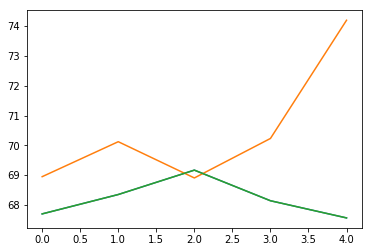

In [69]:
import matplotlib.pyplot as plt

loss = history.history['loss']
loss2 = history.history['val_loss']
num_epochs = np.arange(5)
plt.plot(num_epochs, loss,loss2)
plt.plot(num_epochs, loss)
#plt.savefig("test16.png") #------# Kommentera bort denna för att undvika att bild sparas i mapp #------#
plt.show()
#plt.savefig("test1.png")

In [63]:
history.history

{'loss': [105.32170161614756,
  92.60550403449056,
  90.9679266812537,
  89.85147898243872,
  89.00605591623057,
  88.59976287664612,
  88.13498686453133,
  87.80640523988427,
  87.68288998008035,
  87.1285900061814,
  86.95630358688166,
  86.5160981253164,
  86.17951088466904,
  85.89750142227975,
  85.72821056919747,
  85.2989752243278,
  85.04311428148728,
  84.90470482914101,
  84.48156626087227,
  84.1873607644968,
  83.95722100740774,
  83.80349446030074,
  83.44971206680036,
  83.22949499579067,
  82.90127502729602,
  82.77784038509242,
  82.37548146024305,
  82.19502541499274,
  82.09008952796353,
  81.8517330055381],
 'mean_squared_error': [105.32170161614756,
  92.60550403449056,
  90.9679266812537,
  89.85147898243872,
  89.00605591623057,
  88.59976287664612,
  88.13498686453133,
  87.80640523988427,
  87.68288998008035,
  87.1285900061814,
  86.95630358688166,
  86.5160981253164,
  86.17951088466904,
  85.89750142227975,
  85.72821056919747,
  85.2989752243278,
  85.043114

In [67]:
# evaluate the model
scores = model.evaluate(X_test, y_test)

print(scores)

#scores2 = model.predict(X_test, y_test)

49346/49346 [==============================] - 1s 28us/step
67.19181771224848
